# Dask DataFrames

<img src="images/dask-dataframe.svg" 
     align="right"
     width="20%"
     alt="Dask dataframes are blocked Pandas dataframes">
     
Dask Dataframes coordinate many Pandas dataframes, partitioned along an index.  They support a large subset of the Pandas API.

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:38909 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every 10 seconds of the year 2000
2.  It splits that year by month, keeping every month as a separate Pandas dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [2]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries()

Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [3]:
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


But the column names and dtypes are known.

In [4]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

Some operations will automatically display the data.

In [5]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [6]:
df.head(3)

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,1050,Bob,-0.20,8.30e-01
2000-01-01 00:00:01,1035,Sarah,0.64,-5.66e-01
2000-01-01 00:00:02,981,Victor,0.24,7.05e-03


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [7]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

Call `.compute()` when you want your result as a Pandas dataframe.

If you started `Client()` above then you may want to watch the status page during computation.

In [8]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [9]:
computed_df

name
Alice      0.57
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.57
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [10]:
df = df.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently

In [11]:
%matplotlib inline

In [12]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,7.45e-03,-3.63e-03
2000-01-01 01:00:00,-5.91e-04,-8.31e-03
2000-01-01 02:00:00,-1.66e-04,1.82e-02
2000-01-01 03:00:00,-2.51e-03,5.96e-03
2000-01-01 04:00:00,3.32e-03,2.96e-03


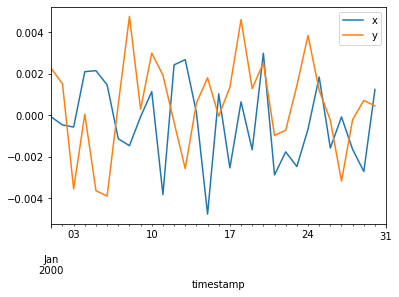

In [13]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [14]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-2.02e-01,0.83
2000-01-01 00:00:01,2.18e-01,0.13
2000-01-01 00:00:02,2.24e-01,0.09
2000-01-01 00:00:03,5.25e-02,0.22
2000-01-01 00:00:04,9.89e-03,0.20


Random access is cheap along the index, but must still be computed.

In [15]:
df.loc['2000-01-05']

,id,name,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,int64,object,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [16]:
%time df.loc['2000-01-05'].compute()

CPU times: user 14.5 ms, sys: 12.4 ms, total: 26.9 ms
Wall time: 42.6 ms


,id,name,x,y
timestamp,,,,
2000-01-05 00:00:00,1005,Ray,0.43,-0.26
2000-01-05 00:00:01,985,Michael,0.53,-0.19
2000-01-05 00:00:02,1075,Oliver,-0.49,-0.05
2000-01-05 00:00:03,1016,Edith,0.41,-0.12
2000-01-05 00:00:04,991,Wendy,0.47,-0.74
...,...,...,...,...
2000-01-05 23:59:55,998,Wendy,-0.34,-0.39
2000-01-05 23:59:56,994,Tim,-0.03,0.15
2000-01-05 23:59:57,978,Laura,-0.68,0.83


## Set Index

Data is sorted by the index column.  This allows for faster access, joins, groupby-apply operations, etc..  However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [17]:
df = df.set_index('name')
df

,id,x,y
npartitions=30,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [18]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name.  As a result oerations like random access are cheap and efficient

In [19]:
%time df.loc['Alice'].compute()

CPU times: user 553 ms, sys: 21.4 ms, total: 574 ms
Wall time: 3.29 s


,id,x,y
name,,,
Alice,1049,0.87,-0.29
Alice,972,0.27,0.46
Alice,1004,-0.35,-0.56
Alice,1003,-0.98,-0.15
Alice,986,0.52,0.66
...,...,...,...
Alice,1038,-0.24,-0.23
Alice,938,-0.39,0.41
Alice,1013,-0.97,-0.78


## Groupby Apply with Scikit-Learn

Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [20]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [21]:
df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression(copy_X=True, fit_intercept=Tr...
Bob        LinearRegression(copy_X=True, fit_intercept=Tr...
Charlie    LinearRegression(copy_X=True, fit_intercept=Tr...
Dan        LinearRegression(copy_X=True, fit_intercept=Tr...
Edith      LinearRegression(copy_X=True, fit_intercept=Tr...
                                 ...                        
Victor     LinearRegression(copy_X=True, fit_intercept=Tr...
Wendy      LinearRegression(copy_X=True, fit_intercept=Tr...
Xavier     LinearRegression(copy_X=True, fit_intercept=Tr...
Yvonne     LinearRegression(copy_X=True, fit_intercept=Tr...
Zelda      LinearRegression(copy_X=True, fit_intercept=Tr...
Length: 26, dtype: object

## Further Reading

For a more in-depth introduction to Dask dataframes, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 04 and 07.